In [682]:
import sys
# the mock-0.3.1 dir contains testcase.py, testutils.py & mock.py
sys.path.append('/home/luca/GitRepositories/Brancher')

import chainer
import chainer.functions as F
import matplotlib.pyplot as plt
import numpy as np

from brancher.distributions import NormalDistribution, LogNormalDistribution
from brancher.variables import DeterministicVariable, RandomVariable, ProbabilisticModel
from brancher.standard_variables import NormalVariable, LogNormalVariable
from brancher import inference
import brancher.functions as BF

In [683]:
# Real model
mu_real = 1.
nu_real = 0.25
x_real = NormalVariable(np.sin(mu_real), nu_real, "x_real")

# Normal model
mu = NormalVariable(0., 2., "mu")
nu = LogNormalVariable(0., 1., "nu")
x = NormalVariable(BF.sin(mu), nu, "x") #TODO: Fix unary operator -
model = ProbabilisticModel([x]) #FIx Repetitions in summary

model.model_summary

,mu_mean,mu_var,mu,nu_mu,nu_sigma,nu,x
Distribution,Deterministic,Deterministic,Normal,Deterministic,Deterministic,Log Normal,Normal
Parents,(),(),"{mu_mean, mu_var}",(),(),"{nu_mu, nu_sigma}","{mu, nu}"
Observed,False,False,False,False,False,False,False


In [684]:
# Print samples
sample = model.get_sample(5)
sample

,mu_mean,mu_var,mu,nu_mu,nu_sigma,nu,x
0,0.0,1.854587,-3.010782,0.0,0.541325,2.429522,0.247744
1,0.0,1.854587,-0.675549,0.0,0.541325,2.299551,0.758448
2,0.0,1.854587,0.726834,0.0,0.541325,1.664260,-2.786458
3,0.0,1.854587,-0.610958,0.0,0.541325,2.051259,0.412679
4,0.0,1.854587,-0.697556,0.0,0.541325,0.533047,-1.667276


In [685]:
# Print samples from single variable
x_sample = x.get_sample(5)
x_sample

,x
0,-0.638042
1,-0.180522
2,-1.345925
3,1.579101
4,-1.807556


In [686]:
# Print samples conditional on an input
in_sample = model.get_sample(5, input_values={mu: 100.})
in_sample

,mu,nu_mu,nu_sigma,nu,x
0,100.0,0.0,0.541325,1.024124,-0.191132
1,100.0,0.0,0.541325,0.625593,-1.390329
2,100.0,0.0,0.541325,2.640614,0.310952
3,100.0,0.0,0.541325,1.580141,0.000643
4,100.0,0.0,0.541325,1.128575,-0.404725


In [687]:
# # Generate data
data = x_real._get_sample(number_samples=10)

# Observe data
x.observe(data[x_real][:, 0, :].data)
model.model_summary

,mu_mean,mu_var,mu,nu_mu,nu_sigma,nu,x
Distribution,Deterministic,Deterministic,Normal,Deterministic,Deterministic,Log Normal,Normal
Parents,(),(),"{mu_mean, mu_var}",(),(),"{nu_mu, nu_sigma}","{mu, nu}"
Observed,False,False,False,False,False,False,True


100%|██████████| 800/800 [00:13<00:00, 60.10it/s]


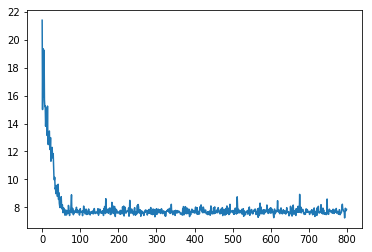

In [688]:
# Variational model
Qmu = NormalVariable(0., 1., "mu", learnable=True)
Qnu = LogNormalVariable(0., 1., "nu", learnable=True)
model.set_posterior_model(ProbabilisticModel([Qmu, Qnu]))

# Inference
inference.stochastic_variational_inference(model,
                                           number_iterations=800,
                                           number_samples=50,
                                           optimizer=chainer.optimizers.Adam(0.05))
loss_list = model.diagnostics["loss curve"]
plt.plot(loss_list)

In [689]:
# print posterior sample
post_sample = model.get_posterior_sample(1000)
post_sample.describe()

,mu,nu,x,mu_var,mu_mean,nu_sigma,nu_mu
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.346926,0.236072,0.887436,-1.615731,1.344209,-0.531787,-1.533271
std,0.427111,0.115217,0.502409,0.000000,0.000000,0.000000,0.000000
min,-0.308945,0.055962,-1.861021,-1.615731,1.344209,-0.531787,-1.533271
25%,1.072476,0.156940,0.587573,-1.615731,1.344209,-0.531787,-1.533271
50%,1.339828,0.210435,0.896537,-1.615731,1.344209,-0.531787,-1.533271
75%,1.637469,0.287341,1.215576,-1.615731,1.344209,-0.531787,-1.533271
max,2.635448,0.842861,2.724580,-1.615731,1.344209,-0.531787,-1.533271


In [690]:
#import seaborn as sns
#sns.distplot(post_samples)
sample = model.get_sample(1000)

In [691]:
sample["mode"] = "Prior"
post_sample["mode"] = "Posterior"
subsample = sample[["mu", "nu", "x", "mode"]]
post_subsample = post_sample[["mu", "nu", "x", "mode"]]
joint_subsample = subsample.append(post_subsample)

/home/luca/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


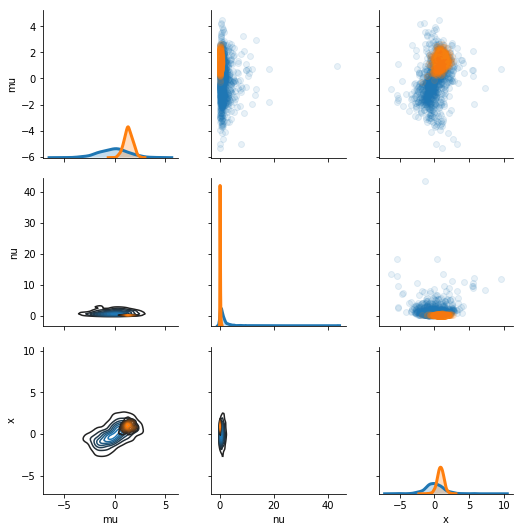

In [692]:
import seaborn as sns

g = sns.PairGrid(joint_subsample, hue="mode")
g.map_upper(plt.scatter, alpha = 0.1)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, shade=True)

(-5, 5)

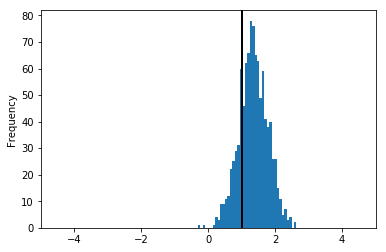

In [693]:
post_sample["mu"].plot.hist(stacked=False, bins=40)
plt.axvline(x=mu_real, c="k", lw=2)
plt.xlim(-5,5)

(0, 6)

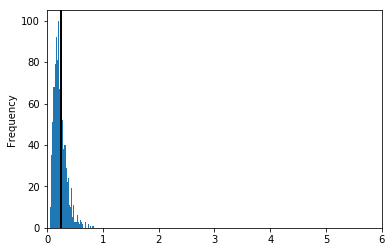

In [694]:
post_sample["nu"].plot.hist(stacked=False, bins=40)
plt.axvline(x=nu_real, c="k", lw=2)
plt.xlim(0,6)